
# REBEL

In [55]:
from transformers import pipeline
import textwrap
import networkx as nx
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import matplotlib.pyplot as plt

In [56]:
from SPARQLWrapper import SPARQLWrapper, JSON

def get_dbpedia_abstract(resource_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    
    # Query to fetch the abstract of a resource from DBpedia
    query = f"""
    SELECT ?abstract
    WHERE {{
        <http://dbpedia.org/resource/{resource_name}> dbo:abstract ?abstract .
        FILTER (langMatches(lang(?abstract), 'en'))
    }}
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    try:
        results = sparql.query().convert()
        abstracts = results["results"]["bindings"]
        
        if abstracts:
            return abstracts[0]["abstract"]["value"]
        else:
            return "Abstract not found for the resource."
    except Exception as e:
        return f"Error: {str(e)}"

resource_name = "Captain_America:_The_First_Avenger"
abstract = get_dbpedia_abstract(resource_name)
print(abstract)

Captain America: The First Avenger is a 2011 American superhero film based on the Marvel Comics character Captain America. Produced by Marvel Studios and distributed by Paramount Pictures, it is the fifth film in the Marvel Cinematic Universe (MCU). The film was directed by Joe Johnston, written by Christopher Markus and Stephen McFeely, and stars Chris Evans as Steve Rogers / Captain America alongside Tommy Lee Jones, Hugo Weaving, Hayley Atwell, Sebastian Stan, Dominic Cooper, Toby Jones, Neal McDonough, Derek Luke, and Stanley Tucci. During World War II, Steve Rogers, a frail man, is transformed into the super-soldier Captain America and must stop the Red Skull (Weaving) from using the Tesseract as an energy source for world domination. The film began as a concept in 1997 and was scheduled for distribution by Artisan Entertainment. However, a lawsuit disrupted the project and was not settled until September 2003. In 2005, Marvel Studios received a loan from Merrill Lynch, and planne

In [ ]:
abstract = "À notre époque, une équipe découvre dans l'Arctique l'épave d'un avion. À l'intérieur elle y trouve un objet circulaire avec un motif rouge, blanc et bleu. L'histoire enchaîne ensuite sur un flashback, qui occupe la quasi-totalité du film.

En mars 1942, Johann Schmidt, chef d'H.Y.D.R.A., l'unité scientifique secrète du Troisième Reich, envahit avec ses troupes la ville de Tønsberg en Norvège pour s'emparer du Tesseract, qui était le joyau le plus précieux du trésor d'Odin.

Dans le New Jersey, en juin 1943, Steve Rogers veut s'engager en tant que militaire, mais sa demande est rejetée suite à ses problèmes physiques et de santé. Après s'être rendu à une exposition à Flushing Meadows « Le monde de demain » avec son ami James “Bucky” Barnes, Rogers fait une nouvelle tentative pour s'engager. Après une petite conversation avec Barnes concernant sa contribution dans la guerre, le Dr. Abraham Erskine autorise Rogers à s'engager. Il est recruté au sein de la S.S.R. (Section Scientifique de Réserve) pour faire partie d'un sous-programme visant à créer une armée de super-soldats, sous le contrôle d'Erskine, du colonel Chester Phillips et de l'agent britannique Peggy Carter. Erskine choisit Rogers pour être le premier super-soldat. Phillips n'est pas d'accord avec le choix d'Erskine, mais il revient sur ses doutes lorsqu'il jette une grenade à blanc que Rogers tente d'intercepter en risquant sa vie pour sauver celle des autres. La nuit qui précède l'expérience destinée à faire de Rogers un super-soldat, Erskine révèle à Rogers que Schmidt avait exigé de recevoir le traitement : mais, le sérum n'étant alors pas au point, il avait souffert d'effets secondaires.

Dans les Alpes, Schmidt et le Dr. Arnim Zola récupèrent avec succès de l'énergie du Tesseract, et Zola veut l'utiliser pour toutes ses créations. Schmidt, après avoir découvert le lieu dans lequel se trouvait Erskine, envoie un assassin pour le tuer. À Brooklyn, Erskine place Rogers pour son expérience et lui injecte un sérum spécial ainsi qu'une dose de « Rayon-Vita ». Après l'expérience, Rogers en ressort musclé et plus grand ; par la suite, l'un des individus du public tue Erskine et se révèle être l'assassin envoyé par Schmidt, Heinz Kruger. Rogers poursuit et capture Kruger, mais l'assassin se suicide en ingérant une petite capsule de cyanure avant d'être interrogé. Dans les Alpes après la poursuite, Schmidt tue 3 envoyés d'Hitler en disant qu'HYDRA ne peut avoir d'avenir sous l'ombre de ce dernier. Ainsi, HYDRA proclame son indépendance vis-a-vis du Troisième Reich.

Erskine mort et sa formule perdue, le sénateur des États-Unis, Brandt, engage Rogers pour jouer nationalement le rôle de « Captain America » pour faire la promotion des obligations de guerre plutôt que de le laisser être étudié par les scientifiques et de tenter de retrouver la formule d'Erskine. En Italie en novembre 1943, alors qu'il joue devant des militaires engagés, Rogers apprend que l'unité de Barnes a été capturée par les forces de Schmidt. Refusant de croire que Barnes est mort, Rogers tente de partir seul à l'aide de Carter et Howard Stark et vole à travers les lignes ennemies. Rogers infiltre la forteresse en possession d'HYDRA, libérant Barnes et les autres soldats capturés. Rogers affronte Schmidt, qui révèle que son visage est en réalité un masque, et le retire pour montrer les effets secondaires que lui a infligé la première version du sérum du Dr Erskine : un visage décharné à la peau écarlate, qui lui a valu son surnom de Crâne Rouge. Schmidt s'échappe et Rogers retourne à la base avec les soldats qu'il a libérés.

Rogers recrute Barnes, Dum Dum Dugan, Gabe Jones, Jim Morita, James Montgomery Falsworth et Jacques Dernier pour attaquer les autres bases d'HYDRA. Stark dote Rogers d'un équipement de pointe, en particulier d'un bouclier circulaire fait à base de vibranium, un métal rare et quasi indestructible. Rogers et son équipe font échouer les opérations d'HYDRA. Plus tard, l'équipe attaque le train de Zola. Ce dernier est capturé, mais Barnes tombe du train et semble y laisser la vie. Grâce à l'information donnée par Zola, la dernière base d'HYDRA est localisée et Rogers mène une attaque contre Schmidt qui veut bombarder les villes américaines à l'aide d'armes de destruction massive. Rogers grimpe à bord de l'avion de Schmidt (la Valkyrie) lors de son décollage. Pendant le combat qui s'ensuit, le Tesseract est endommagé ; Schmidt le prend à mains nues et il est littéralement dissous dans une lumière. Le Tesseract tombe au sol de la Valkyrie, le brûle et tombe sur Terre. Voyant qu'il n'y a aucun moyen de faire atterrir la Valkyrie sans risquer de faire exploser les armes, Rogers se crashe en Arctique. Stark retrouve plus tard le Tesseract dans l'océan, mais il est incapable de localiser Rogers ou la Valkyrie.

Rogers se réveille dans un hôpital des années 1940. Après avoir déduit que quelque chose n'allait pas lors d'une diffusion de radio anachronique, il se rend compte que sa chambre n'est qu'un décor. Il fuit dehors et se retrouve dans le Times Square contemporain. Là, Nick Fury l'informe qu'il a dormi pendant « près de 70 ans ». Avant que le générique de fin ne commence, Steve dit : « J'ai raté un rendez-vous. ».

La scène post-générique est la scène du film Avengers où Nick Fury lui parle de l'Initiative Avengers, qui est suivi par la bande annonce de ce dernier."

In [57]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [58]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [59]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [60]:
def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 128,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [61]:
kb = from_text_to_kb(abstract, verbose=True)
kb.print()

Input has 399 tokens
Input has 4 spans
Span boundaries are [[0, 128], [90, 218], [180, 308], [270, 398]]
Relations:
  {'head': 'Captain America', 'type': 'instance of', 'tail': 'superhero film', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'publisher', 'tail': 'Marvel Comics', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'conflict', 'tail': 'World War II', 'meta': {'spans': [[0, 128], [90, 218]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Chris Evans', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Tommy Lee Jones', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Hugo Weaving', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Hayley Atwell', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Sebastian Stan', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Capt

In [62]:
G = nx.DiGraph()

relation = {}
k = 0
for i, elem in enumerate(kb.relations):
    if elem['tail'] not in relation:
        relation[elem['tail']] = k
        G.add_node(k, name = relation[elem['tail']])
        k += 1
        
    if elem['head'] not in relation:
        relation[elem['head']] = k
        G.add_node(k, name=elem['head'])
        k += 1

    G.add_edge(relation[elem['head']], relation[elem['tail']], name = elem['type'])

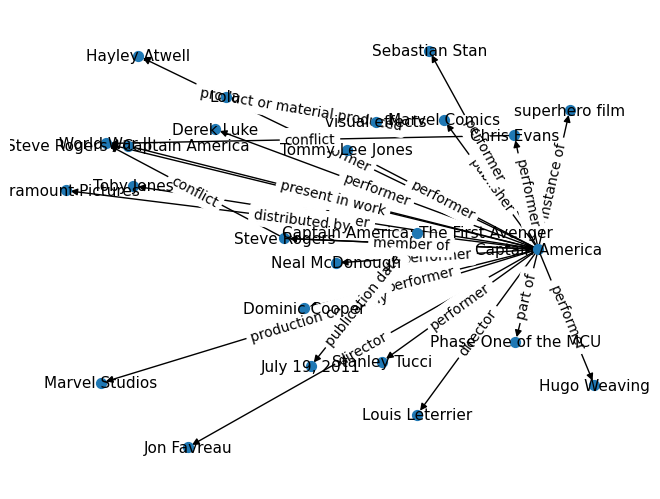

In [63]:
inv_map = {v: k for k, v in relation.items()}
pos = nx.random_layout(G)
edge_labels = dict([((n1, n2), d['name'])
                    for n1, n2, d in G.edges(data=True)])

options = {
    'labels':inv_map,
    'with_labels':True,
    'node_size': 50,
    'pos': pos,
    'font_size':11
}

nx.draw(G, **options)
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
plt.show()

In [64]:
from rdflib import Graph, Literal, Namespace
from rdflib import RDF

g = Graph()
ns = Namespace("http://projet.fr/text/")

In [65]:
for node in G.nodes():
    name = inv_map.get(node)
    head = name.replace(' ','_')
    #g.add((ns[head], ns.name, Literal(node)))
    
    g.add((ns[head], ns["name"], Literal(name)))
    g.add((ns[head], RDF.type, ns['Node']))  # Example mapping node to RDF type 'Node'

In [66]:
for edge in G.edges(data=True):
    print(edge)
    
    source, target, data = edge
    source = inv_map.get(source).replace(' ','_')
    name = inv_map.get(target)
    target = name.replace(' ','_')
        
        
    property = data['name'].replace(" ","_")
    g.add((ns[source], ns[property], ns[target]))
    
      
    g.add((ns[source], ns[property], ns[target])) 

(1, 0, {'name': 'instance of'})
(1, 2, {'name': 'publisher'})
(1, 3, {'name': 'conflict'})
(1, 4, {'name': 'performer'})
(1, 5, {'name': 'performer'})
(1, 6, {'name': 'performer'})
(1, 7, {'name': 'performer'})
(1, 8, {'name': 'performer'})
(1, 9, {'name': 'performer'})
(1, 10, {'name': 'performer'})
(1, 11, {'name': 'performer'})
(1, 12, {'name': 'performer'})
(1, 13, {'name': 'performer'})
(1, 15, {'name': 'has part'})
(1, 16, {'name': 'production company'})
(1, 17, {'name': 'director'})
(1, 18, {'name': 'director'})
(1, 19, {'name': 'distributed by'})
(1, 24, {'name': 'part of'})
(4, 3, {'name': 'conflict'})
(14, 1, {'name': 'present in work'})
(15, 3, {'name': 'conflict'})
(15, 1, {'name': 'member of'})
(21, 20, {'name': 'publication date'})
(23, 22, {'name': 'product or material produced'})


In [67]:
g.serialize(destination="extracted_text.ttl", format="turtle")

<Graph identifier=Na64a2a240c8547b8bd9c4097e6cef94c (<class 'rdflib.graph.Graph'>)>